In [1]:
import os
import cv2

from helpers.DatasetProcess import dataset_to_df, search_df
from helpers.WaveletPacket import wp_decompose,plot_wp_nodes,plot_wp_fun

import numpy as np
# import pandas as pd

from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import ImageGrid


import torch
from torch import nn, einsum
import torch.nn.functional as F


# The cross-entropy loss penalizes the model more when it is more confident in the incorrect class
from torch.nn import CrossEntropyLoss

# Adam is an optimization algorithm that can be used instead of the classical SGD procedure
# to update network weights iterative based in training data.
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import transforms
from torchvision.transforms import v2
from torchvision.io import read_image

from torchinfo import summary

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

In [2]:
print(f"torch version: {torch.__version__}")
print(f"GPU Card: {torch.cuda.get_device_name(0)}")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Torch is using device:', device)
torch.cuda.get_device_name(device)

NUM_WORKERS = os.cpu_count()
print("CPU Count:", NUM_WORKERS)

torch version: 2.2.1+cu121
GPU Card: NVIDIA GeForce RTX 3070 Ti Laptop GPU
Torch is using device: cuda:0
CPU Count: 20


In [3]:
training_phase = 1

In [4]:
model_type = "vit"
add_extra_epochs = True  # if True then continue for extra epochs from the starting epoch

# If True load a pretrained model, and start_epoch = epoch of the model . Else if False then start_epoch = 0
start_from_model = False

In [5]:
model_state_path = f"../../../weights/{model_type}_cifak/checkpoint/"

model_file_name = f"vit_patch8_cifak_epoch_394"  # file name of the saved model

checkpoint = torch.load(model_state_path+model_file_name)

In [6]:
if start_from_model:
    training_phase_lst = checkpoint['training_phase_lst']
    training_phase = training_phase_lst[-1]+1

print(training_phase)


1


In [7]:
# Wavelet Packet Transform Hyper Parameters
wpt_fun = 'db2'
wpt_level = 2
wpt_format = "Stack_ImgUseSameSize"
wpt_ch = ((2**wpt_level)**2)
img_and_wpt_channels = 3+wpt_ch
print(img_and_wpt_channels)

19


In [8]:
img_trans_norm_mean = [0.4913997551666284, 0.48215855929893703, 0.4465309133731618]
img_trans_norm_std = [0.24703225141799082, 0.24348516474564, 0.26158783926049628]

In [9]:
img_size = 32  # Input image height/width in pixels
patch_size = 8 # The height/width of a patch in pixels (patch is a slice of an image)

image_patch_flat_size = img_and_wpt_channels*patch_size**2 #3 Channels x height x width
embed_size = image_patch_flat_size
mlp_dim = 384 # dim of the last mlp classifier

train_batch_size = 512 # https://www.youtube.com/watch?v=Owm1H0ukjS4
valid_batch_size = 512

num_classes = 2
encoder_depth = 4
attention_heads = 32

print(f'Flattened dimension size(of a patch): {image_patch_flat_size}')
print(f'Embedding Size: {embed_size}')
print(f'Output MLP size: {mlp_dim}')

Flattened dimension size(of a patch): 1216
Embedding Size: 1216
Output MLP size: 384


In [10]:
n_extra_epochs = 400
max_epochs = 200

start_epoch = checkpoint['epoch'] if start_from_model else 0
end_epoch = start_epoch + n_extra_epochs if add_extra_epochs else max_epochs
delta_epochs = end_epoch-start_epoch

print(f"Train another {delta_epochs} epochs after epoch {start_epoch} ")

Train another 400 epochs after epoch 0 


In [11]:
base_lr = 0.005         # Base Learning rate 0.1 for SGD , 0.0001 for Adam
momentum = 0.9          # Momentum for SGD
weight_decay = 0.03     # Weight decay for Adam


loss_algo = CrossEntropyLoss

optimize_algo = SGD
optimize_args = {"lr": base_lr,
                #  "weight_decay": weight_decay,
                #  "momentum": momentum  # comment momentum for Adam
                 }

use_scheduler = False
schedule_algo = CosineAnnealingLR
schedule_args = {"T_max": delta_epochs}

In [12]:
hyper_parameters = {
    "training_phase": training_phase,
    "model_type": model_type,
    "wpt_fun": wpt_fun,
    "wpt_level": wpt_level,
    "wpt_format": wpt_format,
    "img_and_wpt_channels": img_and_wpt_channels,
    "img_trans_norm_mean": img_trans_norm_mean,
    "img_trans_norm_std": img_trans_norm_std,
    "img_size": img_size,
    "patch_size": patch_size,
    "image_patch_flat_size": image_patch_flat_size,
    "embed_size": embed_size,
    "mlp_dim": mlp_dim,
    "train_batch_size": train_batch_size,
    "valid_batch_size": valid_batch_size,
    "num_classes": num_classes,
    "encoder_depth": encoder_depth,
    "attention_heads": attention_heads,
    "n_extra_epochs ": n_extra_epochs,
    "base_lr": base_lr,
    "momentum": momentum,
    "weight_decay": weight_decay,
    "loss_algo": loss_algo,
    "optimize_algo": optimize_algo,
    "optimize_args": optimize_args,
    "use_scheduler": use_scheduler,
    "schedule_algo": schedule_algo,
    "schedule_args": schedule_args
}

In [13]:
hyper_parameters

{'training_phase': 1,
 'model_type': 'vit',
 'wpt_fun': 'db2',
 'wpt_level': 2,
 'wpt_format': 'Stack_ImgUseSameSize',
 'img_and_wpt_channels': 19,
 'img_trans_norm_mean': [0.4913997551666284,
  0.48215855929893703,
  0.4465309133731618],
 'img_trans_norm_std': [0.24703225141799082,
  0.24348516474564,
  0.2615878392604963],
 'img_size': 32,
 'patch_size': 8,
 'image_patch_flat_size': 1216,
 'embed_size': 1216,
 'mlp_dim': 384,
 'train_batch_size': 512,
 'valid_batch_size': 512,
 'num_classes': 2,
 'encoder_depth': 4,
 'attention_heads': 32,
 'n_extra_epochs ': 400,
 'base_lr': 0.005,
 'momentum': 0.9,
 'weight_decay': 0.03,
 'loss_algo': torch.nn.modules.loss.CrossEntropyLoss,
 'optimize_algo': torch.optim.sgd.SGD,
 'optimize_args': {'lr': 0.005},
 'use_scheduler': False,
 'schedule_algo': torch.optim.lr_scheduler.CosineAnnealingLR,
 'schedule_args': {'T_max': 400}}

In [14]:
path = '../../../data/CIFAK'
relative_paths = ["/train/REAL", "/train/FAKE", "/test/REAL", "/test/FAKE"]
paths_classes = ["REAL", "FAKE", "REAL", "FAKE"]

In [15]:
df_all, df_train, df_val, df_test, classes_stats = dataset_to_df(path, relative_paths, paths_classes, 0.8, 0.19, 0.01)
classes_stats

,REAL,FAKE,Total
Training,48000,48000,96000
Validation,11400,11400,22800
Testing,600,600,1200
Row_Total,60000,60000,120000


In [16]:
print("First and Last Elements in the Whole dataset")
df_all.iloc[[0,-1]]

First and Last Elements in the Whole dataset


,Image_path,Image_size,Class,Class_Codes,Class_Onehot
0,../../../data/CIFAK//train/REAL/0000(10).jpg,"(3, 32, 32)",REAL,1,"[1, 0]"
119999,../../../data/CIFAK//test/FAKE/999.jpg,"(3, 32, 32)",FAKE,0,"[0, 1]"


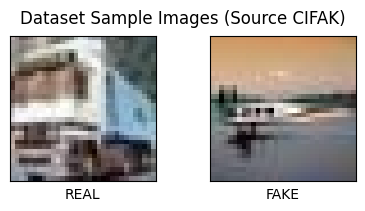

In [17]:
fig, axs = plt.subplots(1, 2, layout="constrained",figsize=(4, 2))

fig.suptitle('Dataset Sample Images (Source CIFAK)')
axs[0].imshow(cv2.imread(df_all.iloc[0, 0]))
axs[0].set(xlabel=df_all.iloc[0, 2])
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].imshow(cv2.imread(df_all.iloc[-1, 0]))
axs[1].set(xlabel=df_all.iloc[-1, 2])
axs[1].set_xticks([])
axs[1].set_yticks([])


plt.show()

In [18]:
def plot_img_grid(holder, data, main_title, Grid2D=True, axes_pad=0.1):

    data_rows = data.shape[0]
    data_cols = data.shape[1]
    if Grid2D:
        nrows = data_rows
        ncols = data_cols
    else:
        nrows = 1
        ncols = data_rows*data_cols

    x_label = range(ncols)
    y_label = range(nrows)

    grid = ImageGrid(holder, 111, (nrows, ncols), axes_pad=axes_pad)

    for i, ax in enumerate(grid):
        r, c = i//data_cols, i % data_cols
        ax.imshow(data[r, c])
        ax.set(xticks=[], yticks=[])
        if Grid2D:
            if r == nrows - 1:
                ax.set_xlabel(x_label[c], rotation=0, fontsize=10, labelpad=20)
            if c == 0:
                ax.set_ylabel(y_label[r], rotation=0, fontsize=10, labelpad=20)
        else:
            ax.set_xlabel(x_label[i], rotation=0, fontsize=10, labelpad=20)
            if i == 0:
                ax.set_ylabel(y_label[i], rotation=0, fontsize=10, labelpad=20)

    holder.suptitle(main_title)

In [19]:
def img_plot(plot, img, slice_width, CHW_Image=True, figsize=(8, 5)):
    # img is passed as torch tensor, hence we need to arrange its shape to suite imshow
    if not isinstance(img, np.ndarray):
        img = img.numpy()

    if CHW_Image:
        img_a = rearrange(img, "c h w -> h w c").astype(np.uint8)
        img_patches_matrix = rearrange(
            img, 'c (row h) (col w) -> row col h w c', h=slice_width, w=slice_width).astype(np.uint8)
    else:
        img_a = img.astype(np.uint8)
        img_patches_matrix = rearrange(
            img, '(row h) (col w) c -> row col h w c', h=slice_width, w=slice_width).astype(np.uint8)

    print("Shape of the image patches matrix: ", img_patches_matrix.shape)

    grid1_text = "Input Image Sliced to Patches"
    grid2_text = "Image Patches Arranged Sequentially Before Enter to Encoder"

    # plt.rcParams['figure.constrained_layout.use'] = True
    fig = plt.figure(figsize=figsize)
    subfigs = fig.subfigures(3, 1, height_ratios=[1, 1, 1], hspace=0.5)

    ax0 = subfigs[0].subplots(1, 1)
    ax0.imshow(img_a)
    ax0.set(xticks=[], yticks=[])
    ax0.set_title("Input Image")

    plot_img_grid(subfigs[1], img_patches_matrix, grid1_text, Grid2D=True)

    plot_img_grid(subfigs[2], img_patches_matrix, grid2_text, Grid2D=False)

In [20]:
# https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit.py
# replaced the attention mechanism with MHA from Sebastian Raschka

# helpers
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.model(x)


# inspired by Sebstian Raschka with modifications
class MHA(nn.Module):
    def __init__(self, embed_dim: int, num_of_head: int = 12, Dropout=0.2) -> None:
        super().__init__()
        self.embed_dim = embed_dim
        self.inner_dim = embed_dim*2
        self.num_of_head = num_of_head
        self.dim_per_head = self.inner_dim // self.num_of_head
        self.Wq = nn.Linear(in_features=embed_dim, out_features=self.inner_dim)
        self.Wk = nn.Linear(in_features=embed_dim, out_features=self.inner_dim)
        self.Wv = nn.Linear(in_features=embed_dim, out_features=self.inner_dim)

        self.dropout = Dropout
        self.linear = nn.Linear(in_features=self.inner_dim, out_features=embed_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        q = self.Wq(x)
        k = self.Wk(x)
        v = self.Wv(x)

        Q = rearrange(q, 'b s (h d) -> b h s d',
                      h=self.num_of_head, d=self.dim_per_head)
        K = rearrange(k, 'b s (h d) -> b h s d',
                      h=self.num_of_head, d=self.dim_per_head)
        V = rearrange(v, 'b s (h d) -> b h s d',
                      h=self.num_of_head, d=self.dim_per_head)

        use_dropout = 0.0 if not self.training else self.dropout

        attention = F.scaled_dot_product_attention(Q, K, V, dropout_p=use_dropout)
        
        # Note:
        # dimensions of tensors inside F.scaled_dot_product_attention as follows:
        # Q(b h s d) . KT(b h d s) ==> b h s s
        # weight(b h s s).V(b h s d) ==> attention (b h s d)

        attention = rearrange(attention, 'b h s d -> b s (h d)')
        attention = self.linear(attention)
        return attention


class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                # PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, MHA(embed_dim=dim, num_of_head=heads, Dropout=dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x


class vit(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool='cls', channels=3, dim_head=64, emb_dropout=0., dropout=0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {
            'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)',
                      p1=patch_height, p2=patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(
            dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim=1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [21]:
# Custom Dataset Class
class Images_Dataset(Dataset):
    def __init__(self, annotations_df, transform=None):

        self.annotation = annotations_df
        self.transform = transform

    def __getitem__(self, index):

        img = read_image(self.annotation.iloc[index, 0])
        labels = torch.tensor(
            self.annotation.iloc[index, 3], dtype=torch.int64)

        if self.transform:
            img_t = self.transform(img)
        else:
            img_t = img

        img_to_wpt = rearrange(img_t, "c h w -> h w c").numpy()
        nodes, *_ = wp_decompose(img_to_wpt, wpt_fun, wpt_level, wpt_format)
        adj_img = nodes[:, :, :3].astype(np.uint8)
        nodes_t = rearrange(torch.from_numpy(nodes), "h w c -> c h w")

        return img, adj_img, nodes_t, labels

    def __len__(self):
        # To return the length of the dataset
        return self.annotation.shape[0]

In [22]:
transform_train = transforms.Compose([
    # Note:
    # We want to introduce augmentation for the dataset using transformations 
    # which doesn't change the real images into fake
    # v2.RandomCrop(32, padding=4),
    # v2.RandomHorizontalFlip(p=0.5),
    transforms.ToPILImage(),
    v2.RandomAffine(degrees=(0, 180), translate=(0.1, 0.3), scale=(0.5, 0.75)),
    # transforms.ToTensor(),
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(img_trans_norm_mean, img_trans_norm_std),
])

transform_valid = transforms.Compose([
    # transforms.ToTensor(),
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(img_trans_norm_mean, img_trans_norm_std),
])

In [23]:
# Define the dataset object and configure the Data Loader

train_set  = Images_Dataset(df_train, transform_train)

train_loader = DataLoader(dataset=train_set,
                          batch_size=train_batch_size,
                          # Drops the last mini batch if less than the batch size (could enhance the model accuracy)
                          drop_last=True,
                          shuffle=True,
                          pin_memory=True,
                          num_workers=NUM_WORKERS)


valid_set  = Images_Dataset(df_val, transform_valid)

valid_loader= DataLoader(dataset=valid_set ,
                          batch_size=valid_batch_size,
                          # Drops the last mini batch if less than the batch size (could enhance the model accuracy)
                          drop_last=True,
                          shuffle=False,
                          pin_memory=True,
                          num_workers=NUM_WORKERS)

In [24]:
print("Total number of training batches:", len(train_loader))
print("Total number of validation batches:", len(valid_loader))

Total number of training batches: 187
Total number of validation batches: 44


In [25]:
sample_img_batch, sample_img_trans_batch, sample_nodes_batch, label_batch = next(
    iter(train_loader))

print(f"Batch of Images Shape: {sample_nodes_batch.size()}")
print(f"Batch of Labels Shape: {label_batch.size()}")
# print(label_batch)


Batch of Images Shape: torch.Size([512, 19, 32, 32])
Batch of Labels Shape: torch.Size([512])


In [26]:
sample_img_idx=12

In [27]:
sample_input_img = sample_img_batch[sample_img_idx, :, :, :]

Text(0.5, 1.0, 'tensor(1)')

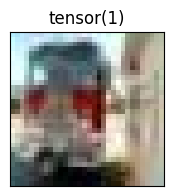

In [28]:
plt.figure(figsize=(2,2))
plt.imshow(rearrange(sample_input_img,"c h w -> h w c").numpy())
plt.xticks([])
plt.yticks([])
plt.title(label_batch[sample_img_idx])

In [29]:
sample_nodes_img=sample_nodes_batch[sample_img_idx,:3,:,:]
print(sample_nodes_img.shape)
sample_nodes_img_np=rearrange(sample_nodes_img,"c h w -> h w c").numpy()

# sample_nodes_img = sample_img_trans_batch[sample_img_idx, :, :, :]
# print(sample_nodes_img.shape)

torch.Size([3, 32, 32])


In [ ]:
print(sample)

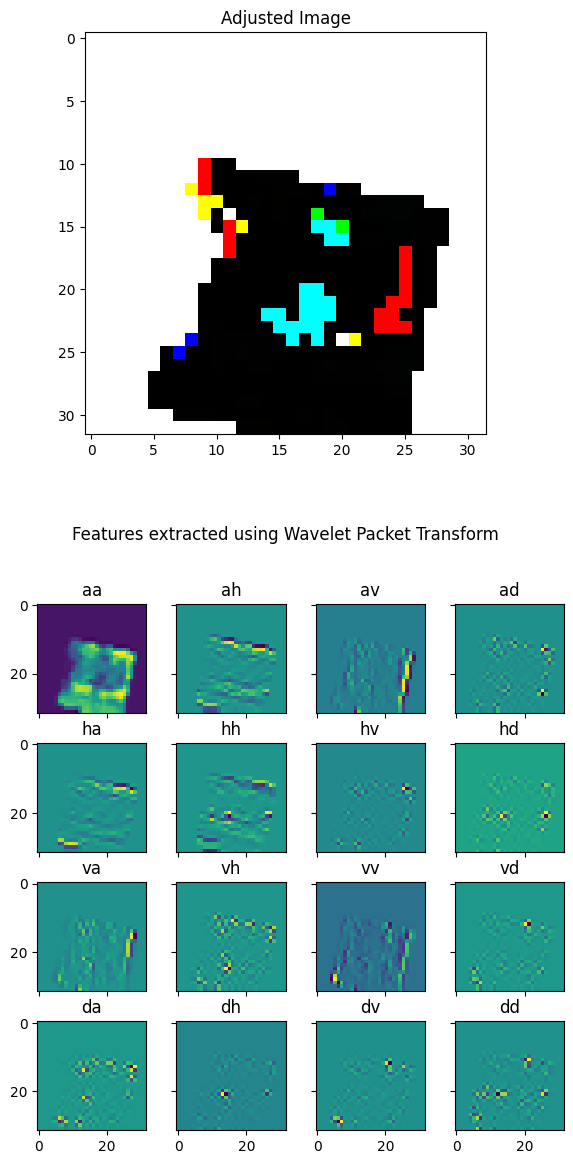

In [30]:
plot_wp_nodes(sample_nodes_img_np, wpt_fun, wpt_level, wpt_format)

Shape of the image patches matrix:  (4, 4, 8, 8, 3)


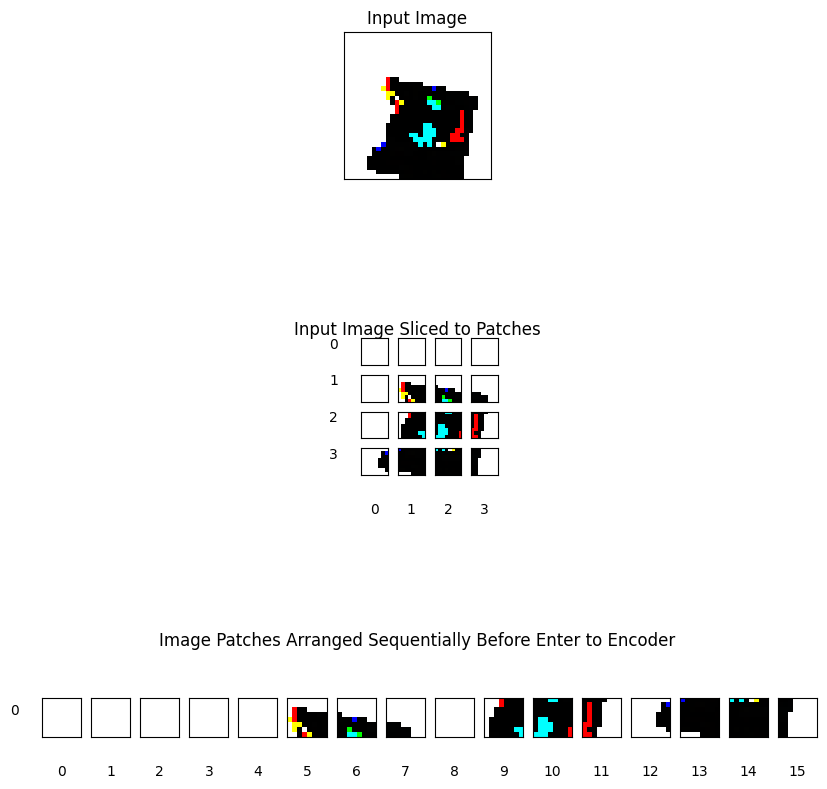

In [31]:
img_plot(plt, sample_nodes_img, patch_size, CHW_Image=True, figsize=(10, 8))

In [32]:
if model_type == "vit":
    model = vit(
        image_size=img_size,
        patch_size=patch_size,
        num_classes=num_classes,
        dim=embed_size,
        depth=encoder_depth,
        heads=attention_heads,
        mlp_dim=mlp_dim,
        emb_dropout=0.1,
        dropout=0.1,
        channels=img_and_wpt_channels
    )
else:
    raise ValueError(
        "You must set the model_type variable to any of: vit ,....")

In [33]:
output = model(sample_nodes_batch)

print("Input Shape: ", sample_nodes_batch.size())
print("Output Shape: ", output.size())

summary(model=model,
        input_size=sample_nodes_batch.size(),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Input Shape:  torch.Size([512, 19, 32, 32])
Output Shape:  torch.Size([512, 2])


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
vit (vit)                                          [512, 19, 32, 32]    [512, 2]             21,888               True
├─Sequential (to_patch_embedding)                  [512, 19, 32, 32]    [512, 16, 1216]      --                   True
│    └─Rearrange (0)                               [512, 19, 32, 32]    [512, 16, 1216]      --                   --
│    └─Linear (1)                                  [512, 16, 1216]      [512, 16, 1216]      1,479,872            True
├─Dropout (dropout)                                [512, 17, 1216]      [512, 17, 1216]      --                   --
├─Transformer (transformer)                        [512, 17, 1216]      [512, 17, 1216]      --                   True
│    └─ModuleList (layers)                         --                   --                   --                   True
│    │    └─ModuleList (0)                     

In [34]:
criterion = loss_algo()
optimizer = optimize_algo(model.parameters(), **optimize_args)
scheduler = schedule_algo(optimizer, **schedule_args)

In [35]:
if start_from_model:
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])

    best_acc = checkpoint['best_acc']
    tr_loss_lst = checkpoint['tr_loss_lst']
    tr_acc_lst = checkpoint['tr_acc_lst']
    val_loss_lst = checkpoint['val_loss_lst']
    val_acc_lst = checkpoint['val_acc_lst']
    optimizer_lst = checkpoint['optimizer_lst']
    running_lr_lst = checkpoint['running_lr_lst']
    training_phase_lst = checkpoint['training_phase_lst']
    hyper_parameters_lst = checkpoint['hyper_parameters_lst']

else:
    best_acc = 0

    tr_loss_lst = []
    tr_acc_lst = []
    val_loss_lst = []
    val_acc_lst = []
    optimizer_lst = []
    running_lr_lst = []
    training_phase_lst=[]
    hyper_parameters_lst = []

In [36]:
model.to(device)
for epoch in range(start_epoch, end_epoch):

    print(f'\n epoch: {epoch+1}/{end_epoch}')

    ##########################################################
    model.train(True)
    tr_loss = 0
    correct = 0
    total = 0
    running_lr = 0

    loop1 = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (*_, inputs, targets) in loop1:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Zero gradients for every batch
        optimizer.zero_grad()
        # Backward path
        loss.backward()

        running_lr += optimizer.param_groups[-1]['lr']

        # Optimizer Step
        optimizer.step()

        tr_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        avg_tr_loss = tr_loss/(batch_idx+1)
        avg_tr_accuracy = 100.*correct/total
        avg_running_lr = running_lr/(batch_idx+1)

        loop1.set_description(f"Train--Epoch [{epoch+1}/{end_epoch}]")
        loop1.set_postfix(loss=avg_tr_loss, acc=avg_tr_accuracy)

    ##########################################################
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():

        loop2 = tqdm(enumerate(valid_loader), total=len(valid_loader))
        for batch_idx, (*_, inputs, targets) in loop2:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            avg_val_loss = val_loss/(batch_idx+1)
            avg_val_accuracy = 100.*correct/total

            loop2.set_description(f"Valid--Epoch [{epoch+1}/{end_epoch}]")
            loop2.set_postfix(loss=avg_val_loss, acc=avg_val_accuracy)
    ##########################################################

    tr_loss_lst.append(avg_tr_loss)
    tr_acc_lst.append(avg_tr_accuracy)
    val_loss_lst.append(avg_val_loss)
    val_acc_lst.append(avg_val_accuracy)
    optimizer_lst.append(type(optimizer).__name__)
    running_lr_lst.append(avg_running_lr)
    training_phase_lst.append(training_phase)
    hyper_parameters_lst.append(hyper_parameters)

    # Save checkpoint.
    if avg_val_accuracy > best_acc:
        best_acc = avg_val_accuracy

        print('Saving..')
        state = {"model": model.state_dict(),
                 "optimizer": optimizer.state_dict(),
                 "epoch": epoch,
                 "best_acc": best_acc,
                 "tr_loss_lst": tr_loss_lst,
                 "tr_acc_lst": tr_acc_lst,
                 "val_loss_lst": val_loss_lst,
                 "val_acc_lst": val_acc_lst,
                 "optimizer_lst": optimizer_lst,
                 "running_lr_lst": running_lr_lst,
                 "training_phase_lst":training_phase_lst,
                 "hyper_parameters_lst": hyper_parameters_lst
                 }
        torch.save(state, model_state_path +
                   f'{model_type}_wpt_cifak_ph{training_phase}_Epoch{epoch}_acc{best_acc:.2f}')

    ##########################################################

    if use_scheduler:
        scheduler.step()  # step scheduling


 epoch: 1/400


Valid--Epoch [1/400]: 100%|██████████| 44/44 [00:08<00:00,  4.91it/s, acc=50, loss=1.84]  


Saving..

 epoch: 2/400


Valid--Epoch [2/400]: 100%|██████████| 44/44 [00:09<00:00,  4.61it/s, acc=57.4, loss=0.733]


Saving..

 epoch: 3/400


Valid--Epoch [3/400]: 100%|██████████| 44/44 [00:09<00:00,  4.65it/s, acc=50, loss=1.62]  


 epoch: 4/400



Valid--Epoch [4/400]: 100%|██████████| 44/44 [00:09<00:00,  4.50it/s, acc=59, loss=0.687]  


Saving..

 epoch: 5/400


Valid--Epoch [5/400]: 100%|██████████| 44/44 [00:09<00:00,  4.42it/s, acc=50, loss=1.24]  


 epoch: 6/400



Valid--Epoch [6/400]: 100%|██████████| 44/44 [00:10<00:00,  4.37it/s, acc=58.8, loss=0.684]


 epoch: 7/400



Valid--Epoch [7/400]: 100%|██████████| 44/44 [00:08<00:00,  4.95it/s, acc=49.5, loss=0.816]


 epoch: 8/400



Valid--Epoch [8/400]: 100%|██████████| 44/44 [00:08<00:00,  5.03it/s, acc=49.8, loss=0.911]


 epoch: 9/400



Valid--Epoch [9/400]: 100%|██████████| 44/44 [00:08<00:00,  5.03it/s, acc=49.9, loss=0.767]


 epoch: 10/400



Valid--Epoch [10/400]: 100%|██████████| 44/44 [00:09<00:00,  4.59it/s, acc=54.1, loss=0.702]


 epoch: 11/400



Valid--Epoch [11/400]: 100%|██████████| 44/44 [00:08<00:00,  5.14it/s, acc=49.6, loss=0.834]


 epoch: 12/400



Valid--Epoch [12/400]: 100%|██████████| 44/44 [00:09<00:00,  4.84it/s, acc=49.8, loss=0.919]


 epoch: 13/400



Valid--Epoch [13/400]: 100%|██████████| 44/44 [00:08<00:00,  5.01it/s, acc=51.9, loss=0.74] 


 epoch: 14/400



Valid--Epoch [14/400]: 100%|██████████| 44/44 [00:08<00:00,  4.93it/s, acc=51.8, loss=0.743]


 epoch: 15/400



Valid--Epoch [15/400]: 100%|██████████| 44/44 [00:08<00:00,  5.05it/s, acc=49.8, loss=0.81] 


 epoch: 16/400



Valid--Epoch [16/400]: 100%|██████████| 44/44 [00:09<00:00,  4.72it/s, acc=54.7, loss=0.707]


 epoch: 17/400



Valid--Epoch [17/400]: 100%|██████████| 44/44 [00:09<00:00,  4.74it/s, acc=53.1, loss=0.724]


 epoch: 18/400



Valid--Epoch [18/400]: 100%|██████████| 44/44 [00:09<00:00,  4.78it/s, acc=49.8, loss=0.918]


 epoch: 19/400



Valid--Epoch [19/400]: 100%|██████████| 44/44 [00:09<00:00,  4.75it/s, acc=50.8, loss=0.798]


 epoch: 20/400



Valid--Epoch [20/400]: 100%|██████████| 44/44 [00:09<00:00,  4.75it/s, acc=50.5, loss=0.812]


 epoch: 21/400



Valid--Epoch [21/400]: 100%|██████████| 44/44 [00:09<00:00,  4.66it/s, acc=51.9, loss=0.759]


 epoch: 22/400



Valid--Epoch [22/400]: 100%|██████████| 44/44 [00:09<00:00,  4.48it/s, acc=50.1, loss=0.859]


 epoch: 23/400



Valid--Epoch [23/400]: 100%|██████████| 44/44 [00:09<00:00,  4.84it/s, acc=50.7, loss=0.827]


 epoch: 24/400



Valid--Epoch [24/400]: 100%|██████████| 44/44 [00:09<00:00,  4.88it/s, acc=51.3, loss=0.807]


 epoch: 25/400



Valid--Epoch [25/400]: 100%|██████████| 44/44 [00:09<00:00,  4.78it/s, acc=49.9, loss=0.898]


 epoch: 26/400



Valid--Epoch [26/400]: 100%|██████████| 44/44 [00:09<00:00,  4.79it/s, acc=52.2, loss=0.783]


 epoch: 27/400



Valid--Epoch [27/400]: 100%|██████████| 44/44 [00:09<00:00,  4.70it/s, acc=52.6, loss=0.76] 


 epoch: 28/400



Valid--Epoch [28/400]: 100%|██████████| 44/44 [00:09<00:00,  4.63it/s, acc=52.5, loss=0.773]


 epoch: 29/400



Valid--Epoch [29/400]: 100%|██████████| 44/44 [00:09<00:00,  4.85it/s, acc=53.3, loss=0.766]


 epoch: 30/400



Valid--Epoch [30/400]: 100%|██████████| 44/44 [00:08<00:00,  5.01it/s, acc=51.9, loss=0.835]


 epoch: 31/400



Valid--Epoch [31/400]: 100%|██████████| 44/44 [00:09<00:00,  4.89it/s, acc=51.3, loss=0.873]


 epoch: 32/400



Valid--Epoch [32/400]: 100%|██████████| 44/44 [00:09<00:00,  4.80it/s, acc=52.1, loss=0.83] 


 epoch: 33/400



Valid--Epoch [33/400]: 100%|██████████| 44/44 [00:09<00:00,  4.72it/s, acc=51.6, loss=0.86] 


 epoch: 34/400



Valid--Epoch [34/400]: 100%|██████████| 44/44 [00:09<00:00,  4.71it/s, acc=51.9, loss=0.881]


 epoch: 35/400



Valid--Epoch [35/400]: 100%|██████████| 44/44 [00:09<00:00,  4.80it/s, acc=54.4, loss=0.802]


 epoch: 36/400



Valid--Epoch [36/400]: 100%|██████████| 44/44 [00:09<00:00,  4.69it/s, acc=52.6, loss=0.856]


 epoch: 37/400



Valid--Epoch [37/400]: 100%|██████████| 44/44 [00:09<00:00,  4.86it/s, acc=54.2, loss=0.81] 


 epoch: 38/400



Valid--Epoch [38/400]: 100%|██████████| 44/44 [00:08<00:00,  4.91it/s, acc=52.4, loss=0.868]


 epoch: 39/400



Valid--Epoch [39/400]: 100%|██████████| 44/44 [00:09<00:00,  4.76it/s, acc=52.2, loss=0.877]


 epoch: 40/400



Valid--Epoch [40/400]: 100%|██████████| 44/44 [00:09<00:00,  4.67it/s, acc=52.4, loss=0.89] 


 epoch: 41/400



Valid--Epoch [41/400]: 100%|██████████| 44/44 [00:09<00:00,  4.78it/s, acc=52.6, loss=0.896]


 epoch: 42/400



Valid--Epoch [42/400]: 100%|██████████| 44/44 [00:09<00:00,  4.62it/s, acc=52.7, loss=0.878]


 epoch: 43/400



Valid--Epoch [43/400]: 100%|██████████| 44/44 [00:09<00:00,  4.57it/s, acc=52.9, loss=0.871]


 epoch: 44/400



Valid--Epoch [44/400]: 100%|██████████| 44/44 [00:09<00:00,  4.67it/s, acc=52.7, loss=0.89] 


 epoch: 45/400



Valid--Epoch [45/400]: 100%|██████████| 44/44 [00:09<00:00,  4.43it/s, acc=53.2, loss=0.879]


 epoch: 46/400



Valid--Epoch [46/400]: 100%|██████████| 44/44 [00:09<00:00,  4.75it/s, acc=52.9, loss=0.888]


 epoch: 47/400



Valid--Epoch [47/400]: 100%|██████████| 44/44 [00:09<00:00,  4.42it/s, acc=52.1, loss=0.965]


 epoch: 48/400



Valid--Epoch [48/400]: 100%|██████████| 44/44 [00:09<00:00,  4.40it/s, acc=52, loss=0.986]  


 epoch: 49/400



Valid--Epoch [49/400]: 100%|██████████| 44/44 [00:09<00:00,  4.48it/s, acc=51.9, loss=0.974]


 epoch: 50/400



Valid--Epoch [50/400]: 100%|██████████| 44/44 [00:08<00:00,  5.09it/s, acc=52.5, loss=0.921]


 epoch: 51/400



Valid--Epoch [51/400]: 100%|██████████| 44/44 [00:09<00:00,  4.67it/s, acc=52.8, loss=0.889]


 epoch: 52/400



Valid--Epoch [52/400]: 100%|██████████| 44/44 [00:09<00:00,  4.48it/s, acc=53.5, loss=0.874]


 epoch: 53/400



Valid--Epoch [53/400]: 100%|██████████| 44/44 [00:10<00:00,  4.35it/s, acc=53.3, loss=0.898]


 epoch: 54/400



Valid--Epoch [54/400]: 100%|██████████| 44/44 [00:09<00:00,  4.72it/s, acc=52.4, loss=0.969]


 epoch: 55/400



Valid--Epoch [55/400]: 100%|██████████| 44/44 [00:09<00:00,  4.63it/s, acc=53.1, loss=0.898]


 epoch: 56/400



Valid--Epoch [56/400]: 100%|██████████| 44/44 [00:09<00:00,  4.62it/s, acc=51.7, loss=1]    


 epoch: 57/400



Valid--Epoch [57/400]: 100%|██████████| 44/44 [00:09<00:00,  4.63it/s, acc=51.6, loss=1.04]


 epoch: 58/400



Valid--Epoch [58/400]: 100%|██████████| 44/44 [00:09<00:00,  4.64it/s, acc=52.1, loss=0.963]


 epoch: 59/400



Valid--Epoch [59/400]: 100%|██████████| 44/44 [00:09<00:00,  4.76it/s, acc=53.1, loss=0.896]


 epoch: 60/400



Valid--Epoch [60/400]: 100%|██████████| 44/44 [00:09<00:00,  4.51it/s, acc=51.9, loss=1]    


 epoch: 61/400



Valid--Epoch [61/400]: 100%|██████████| 44/44 [00:09<00:00,  4.58it/s, acc=52.3, loss=0.945]


 epoch: 62/400



Valid--Epoch [62/400]: 100%|██████████| 44/44 [00:09<00:00,  4.72it/s, acc=51.8, loss=0.987]


 epoch: 63/400



Valid--Epoch [63/400]: 100%|██████████| 44/44 [00:09<00:00,  4.68it/s, acc=51.5, loss=1.01]


 epoch: 64/400



Valid--Epoch [64/400]: 100%|██████████| 44/44 [00:09<00:00,  4.77it/s, acc=52.2, loss=0.937]


 epoch: 65/400



Valid--Epoch [65/400]: 100%|██████████| 44/44 [00:09<00:00,  4.57it/s, acc=52.1, loss=0.952]


 epoch: 66/400



Valid--Epoch [66/400]: 100%|██████████| 44/44 [00:09<00:00,  4.71it/s, acc=52, loss=0.979]  


 epoch: 67/400



Valid--Epoch [67/400]: 100%|██████████| 44/44 [00:09<00:00,  4.71it/s, acc=51.6, loss=1.02]


 epoch: 68/400



Valid--Epoch [68/400]: 100%|██████████| 44/44 [00:09<00:00,  4.71it/s, acc=52.1, loss=0.967]


 epoch: 69/400



Valid--Epoch [69/400]: 100%|██████████| 44/44 [00:09<00:00,  4.54it/s, acc=52.5, loss=0.898]


 epoch: 70/400



Valid--Epoch [70/400]: 100%|██████████| 44/44 [00:09<00:00,  4.83it/s, acc=51.9, loss=1.03]


 epoch: 71/400



Valid--Epoch [71/400]: 100%|██████████| 44/44 [00:09<00:00,  4.83it/s, acc=52, loss=0.949]  


 epoch: 72/400



Valid--Epoch [72/400]: 100%|██████████| 44/44 [00:09<00:00,  4.77it/s, acc=51.5, loss=1.01]


 epoch: 73/400



Valid--Epoch [73/400]: 100%|██████████| 44/44 [00:09<00:00,  4.84it/s, acc=52.3, loss=0.917]


 epoch: 74/400



Valid--Epoch [74/400]: 100%|██████████| 44/44 [00:09<00:00,  4.44it/s, acc=52, loss=0.957]  


 epoch: 75/400



Valid--Epoch [75/400]: 100%|██████████| 44/44 [00:09<00:00,  4.81it/s, acc=51.7, loss=0.986]


 epoch: 76/400



Valid--Epoch [76/400]: 100%|██████████| 44/44 [00:08<00:00,  4.93it/s, acc=51.6, loss=1.02]


 epoch: 77/400



Valid--Epoch [77/400]: 100%|██████████| 44/44 [00:08<00:00,  4.92it/s, acc=51.1, loss=1.13]


 epoch: 78/400



Valid--Epoch [78/400]: 100%|██████████| 44/44 [00:09<00:00,  4.83it/s, acc=51.8, loss=1.01]


 epoch: 79/400



Valid--Epoch [79/400]: 100%|██████████| 44/44 [00:08<00:00,  4.92it/s, acc=51.9, loss=0.966]


 epoch: 80/400



Valid--Epoch [80/400]: 100%|██████████| 44/44 [00:08<00:00,  5.09it/s, acc=51.7, loss=1.04]


 epoch: 81/400



Valid--Epoch [81/400]: 100%|██████████| 44/44 [00:08<00:00,  5.05it/s, acc=52.9, loss=0.874]


 epoch: 82/400



Valid--Epoch [82/400]: 100%|██████████| 44/44 [00:09<00:00,  4.70it/s, acc=52.1, loss=0.965]


 epoch: 83/400



Valid--Epoch [83/400]: 100%|██████████| 44/44 [00:08<00:00,  5.17it/s, acc=52.3, loss=0.948]


 epoch: 84/400



Valid--Epoch [84/400]: 100%|██████████| 44/44 [00:08<00:00,  4.89it/s, acc=52.1, loss=0.964]


 epoch: 85/400



Valid--Epoch [85/400]: 100%|██████████| 44/44 [00:08<00:00,  4.91it/s, acc=52.7, loss=0.928]


 epoch: 86/400



Valid--Epoch [86/400]: 100%|██████████| 44/44 [00:08<00:00,  4.89it/s, acc=52.2, loss=0.981]


 epoch: 87/400



Valid--Epoch [87/400]: 100%|██████████| 44/44 [00:08<00:00,  4.96it/s, acc=52.3, loss=0.986]


 epoch: 88/400



Valid--Epoch [88/400]: 100%|██████████| 44/44 [00:08<00:00,  4.94it/s, acc=52.4, loss=1.01] 


 epoch: 89/400



Valid--Epoch [89/400]: 100%|██████████| 44/44 [00:08<00:00,  5.16it/s, acc=52.1, loss=1.04]


 epoch: 90/400



Valid--Epoch [90/400]: 100%|██████████| 44/44 [00:08<00:00,  5.12it/s, acc=52.9, loss=0.971]


 epoch: 91/400



Valid--Epoch [91/400]: 100%|██████████| 44/44 [00:08<00:00,  4.90it/s, acc=52.6, loss=0.964]


 epoch: 92/400



Valid--Epoch [92/400]: 100%|██████████| 44/44 [00:08<00:00,  5.01it/s, acc=52.8, loss=0.966]


 epoch: 93/400



Valid--Epoch [93/400]: 100%|██████████| 44/44 [00:09<00:00,  4.74it/s, acc=53.3, loss=0.926]


 epoch: 94/400



Valid--Epoch [94/400]: 100%|██████████| 44/44 [00:09<00:00,  4.82it/s, acc=53.2, loss=0.948]


 epoch: 95/400



Valid--Epoch [95/400]: 100%|██████████| 44/44 [00:08<00:00,  4.90it/s, acc=53.2, loss=0.962]


 epoch: 96/400



Valid--Epoch [96/400]: 100%|██████████| 44/44 [00:09<00:00,  4.58it/s, acc=53.4, loss=0.97] 


 epoch: 97/400



Valid--Epoch [97/400]: 100%|██████████| 44/44 [00:09<00:00,  4.88it/s, acc=53.6, loss=0.929]


 epoch: 98/400



Valid--Epoch [98/400]: 100%|██████████| 44/44 [00:08<00:00,  5.01it/s, acc=53.4, loss=0.96] 


 epoch: 99/400



Valid--Epoch [99/400]: 100%|██████████| 44/44 [00:08<00:00,  4.96it/s, acc=53.5, loss=0.96] 


 epoch: 100/400



Valid--Epoch [100/400]: 100%|██████████| 44/44 [00:08<00:00,  4.89it/s, acc=54, loss=0.913]  


 epoch: 101/400



Valid--Epoch [101/400]: 100%|██████████| 44/44 [00:08<00:00,  5.17it/s, acc=54.3, loss=0.884]


 epoch: 102/400



Valid--Epoch [102/400]: 100%|██████████| 44/44 [00:08<00:00,  5.16it/s, acc=54.2, loss=0.931]


 epoch: 103/400



Valid--Epoch [103/400]: 100%|██████████| 44/44 [00:08<00:00,  5.03it/s, acc=54, loss=0.937]  


 epoch: 104/400



Valid--Epoch [104/400]: 100%|██████████| 44/44 [00:08<00:00,  4.95it/s, acc=54.1, loss=0.969]


 epoch: 105/400



Valid--Epoch [105/400]: 100%|██████████| 44/44 [00:09<00:00,  4.78it/s, acc=54.5, loss=0.915]


 epoch: 106/400



Valid--Epoch [106/400]: 100%|██████████| 44/44 [00:09<00:00,  4.86it/s, acc=54.8, loss=0.946]


 epoch: 107/400



Valid--Epoch [107/400]: 100%|██████████| 44/44 [00:09<00:00,  4.59it/s, acc=54, loss=1.02]  


 epoch: 108/400



Valid--Epoch [108/400]: 100%|██████████| 44/44 [00:09<00:00,  4.83it/s, acc=55, loss=0.912]  


 epoch: 109/400



Valid--Epoch [109/400]: 100%|██████████| 44/44 [00:09<00:00,  4.62it/s, acc=55.2, loss=0.91] 


 epoch: 110/400



Valid--Epoch [110/400]: 100%|██████████| 44/44 [00:09<00:00,  4.80it/s, acc=54.8, loss=1.01]


 epoch: 111/400



Valid--Epoch [111/400]: 100%|██████████| 44/44 [00:08<00:00,  5.03it/s, acc=55.5, loss=0.902]


 epoch: 112/400



Valid--Epoch [112/400]: 100%|██████████| 44/44 [00:08<00:00,  5.12it/s, acc=55.6, loss=0.935]


 epoch: 113/400



Valid--Epoch [113/400]: 100%|██████████| 44/44 [00:09<00:00,  4.87it/s, acc=55.4, loss=0.908]


 epoch: 114/400



Valid--Epoch [114/400]: 100%|██████████| 44/44 [00:08<00:00,  5.08it/s, acc=55.4, loss=0.968]


 epoch: 115/400



Valid--Epoch [115/400]: 100%|██████████| 44/44 [00:08<00:00,  5.24it/s, acc=55.4, loss=0.963]


 epoch: 116/400



Valid--Epoch [116/400]: 100%|██████████| 44/44 [00:08<00:00,  5.23it/s, acc=55.9, loss=0.903]


 epoch: 117/400



Valid--Epoch [117/400]: 100%|██████████| 44/44 [00:08<00:00,  4.90it/s, acc=55.6, loss=0.942]


 epoch: 118/400



Valid--Epoch [118/400]: 100%|██████████| 44/44 [00:08<00:00,  5.08it/s, acc=56.2, loss=0.894]


 epoch: 119/400



Valid--Epoch [119/400]: 100%|██████████| 44/44 [00:08<00:00,  4.92it/s, acc=56.1, loss=0.911]


 epoch: 120/400



Valid--Epoch [120/400]: 100%|██████████| 44/44 [00:08<00:00,  5.07it/s, acc=55.9, loss=0.93] 


 epoch: 121/400



Valid--Epoch [121/400]: 100%|██████████| 44/44 [00:08<00:00,  5.17it/s, acc=56.2, loss=0.929]


 epoch: 122/400



Valid--Epoch [122/400]: 100%|██████████| 44/44 [00:08<00:00,  5.05it/s, acc=56.2, loss=0.917]


 epoch: 123/400



Valid--Epoch [123/400]: 100%|██████████| 44/44 [00:09<00:00,  4.80it/s, acc=56.7, loss=0.859]


 epoch: 124/400



Valid--Epoch [124/400]: 100%|██████████| 44/44 [00:08<00:00,  5.17it/s, acc=56.3, loss=0.9]  


 epoch: 125/400



Valid--Epoch [125/400]: 100%|██████████| 44/44 [00:08<00:00,  4.94it/s, acc=56.7, loss=0.93] 


 epoch: 126/400



Valid--Epoch [126/400]: 100%|██████████| 44/44 [00:09<00:00,  4.86it/s, acc=56.8, loss=0.939]


 epoch: 127/400



Valid--Epoch [127/400]: 100%|██████████| 44/44 [00:08<00:00,  4.93it/s, acc=56.5, loss=0.923]


 epoch: 128/400



Valid--Epoch [128/400]: 100%|██████████| 44/44 [00:08<00:00,  5.12it/s, acc=56.6, loss=0.968]



 epoch: 129/400


Valid--Epoch [129/400]: 100%|██████████| 44/44 [00:08<00:00,  4.91it/s, acc=56.9, loss=0.934]


 epoch: 130/400



Valid--Epoch [130/400]: 100%|██████████| 44/44 [00:08<00:00,  5.22it/s, acc=57.8, loss=0.826]


 epoch: 131/400



Valid--Epoch [131/400]: 100%|██████████| 44/44 [00:08<00:00,  5.04it/s, acc=56.5, loss=0.958]


 epoch: 132/400



Valid--Epoch [132/400]: 100%|██████████| 44/44 [00:08<00:00,  5.23it/s, acc=57.7, loss=0.856]


 epoch: 133/400



Valid--Epoch [133/400]: 100%|██████████| 44/44 [00:09<00:00,  4.88it/s, acc=57.5, loss=0.88] 


 epoch: 134/400



Valid--Epoch [134/400]: 100%|██████████| 44/44 [00:08<00:00,  4.97it/s, acc=57.8, loss=0.88] 


 epoch: 135/400



Valid--Epoch [135/400]: 100%|██████████| 44/44 [00:08<00:00,  4.95it/s, acc=57.5, loss=0.92] 


 epoch: 136/400



Valid--Epoch [136/400]: 100%|██████████| 44/44 [00:08<00:00,  5.08it/s, acc=56.8, loss=0.98] 


 epoch: 137/400



Valid--Epoch [137/400]: 100%|██████████| 44/44 [00:08<00:00,  4.93it/s, acc=57.7, loss=0.884]


 epoch: 138/400



Valid--Epoch [138/400]: 100%|██████████| 44/44 [00:08<00:00,  5.10it/s, acc=57.4, loss=0.91] 


 epoch: 139/400



Valid--Epoch [139/400]: 100%|██████████| 44/44 [00:08<00:00,  4.89it/s, acc=57.5, loss=0.942]


 epoch: 140/400



Valid--Epoch [140/400]: 100%|██████████| 44/44 [00:08<00:00,  5.05it/s, acc=57.9, loss=0.891]


 epoch: 141/400



Valid--Epoch [141/400]: 100%|██████████| 44/44 [00:08<00:00,  4.97it/s, acc=58.2, loss=0.85] 


 epoch: 142/400



Valid--Epoch [142/400]: 100%|██████████| 44/44 [00:08<00:00,  5.09it/s, acc=57.8, loss=0.926]


 epoch: 143/400



Valid--Epoch [143/400]: 100%|██████████| 44/44 [00:08<00:00,  5.10it/s, acc=58.6, loss=0.854]


 epoch: 144/400



Valid--Epoch [144/400]: 100%|██████████| 44/44 [00:08<00:00,  5.11it/s, acc=58.2, loss=0.89] 


 epoch: 145/400



Valid--Epoch [145/400]: 100%|██████████| 44/44 [00:09<00:00,  4.74it/s, acc=59.1, loss=0.815]


Saving..

 epoch: 146/400


Valid--Epoch [146/400]: 100%|██████████| 44/44 [00:08<00:00,  4.91it/s, acc=58.3, loss=0.893]


 epoch: 147/400



Valid--Epoch [147/400]: 100%|██████████| 44/44 [00:09<00:00,  4.81it/s, acc=58.1, loss=0.947]


 epoch: 148/400



Valid--Epoch [148/400]: 100%|██████████| 44/44 [00:08<00:00,  5.07it/s, acc=58.5, loss=0.87] 


 epoch: 149/400



Valid--Epoch [149/400]: 100%|██████████| 44/44 [00:08<00:00,  5.20it/s, acc=59, loss=0.838]  


 epoch: 150/400



Valid--Epoch [150/400]: 100%|██████████| 44/44 [00:09<00:00,  4.86it/s, acc=58.3, loss=0.897]


 epoch: 151/400



Valid--Epoch [151/400]: 100%|██████████| 44/44 [00:08<00:00,  4.97it/s, acc=58.7, loss=0.878]


 epoch: 152/400



Valid--Epoch [152/400]: 100%|██████████| 44/44 [00:08<00:00,  5.20it/s, acc=58.9, loss=0.851]


 epoch: 153/400



Valid--Epoch [153/400]: 100%|██████████| 44/44 [00:08<00:00,  5.00it/s, acc=58.3, loss=0.934]


 epoch: 154/400



Valid--Epoch [154/400]: 100%|██████████| 44/44 [00:09<00:00,  4.86it/s, acc=59.1, loss=0.859]


Saving..

 epoch: 155/400


Valid--Epoch [155/400]: 100%|██████████| 44/44 [00:08<00:00,  5.01it/s, acc=58.5, loss=0.932]


 epoch: 156/400



Valid--Epoch [156/400]: 100%|██████████| 44/44 [00:08<00:00,  5.03it/s, acc=59.2, loss=0.871]


Saving..

 epoch: 157/400


Valid--Epoch [157/400]: 100%|██████████| 44/44 [00:09<00:00,  4.89it/s, acc=59.2, loss=0.871]


 epoch: 158/400



Valid--Epoch [158/400]: 100%|██████████| 44/44 [00:08<00:00,  4.92it/s, acc=59, loss=0.877]  


 epoch: 159/400



Valid--Epoch [159/400]: 100%|██████████| 44/44 [00:08<00:00,  5.22it/s, acc=58, loss=0.969]  


 epoch: 160/400



Valid--Epoch [160/400]: 100%|██████████| 44/44 [00:08<00:00,  5.12it/s, acc=59.5, loss=0.865]


Saving..

 epoch: 161/400


Valid--Epoch [161/400]: 100%|██████████| 44/44 [00:08<00:00,  4.91it/s, acc=59.6, loss=0.862]


Saving..

 epoch: 162/400


Valid--Epoch [162/400]: 100%|██████████| 44/44 [00:08<00:00,  5.20it/s, acc=59, loss=0.901]  


 epoch: 163/400



Valid--Epoch [163/400]: 100%|██████████| 44/44 [00:08<00:00,  4.96it/s, acc=59.9, loss=0.839]


Saving..

 epoch: 164/400


Valid--Epoch [164/400]: 100%|██████████| 44/44 [00:08<00:00,  5.23it/s, acc=59.9, loss=0.847]


 epoch: 165/400



Valid--Epoch [165/400]: 100%|██████████| 44/44 [00:08<00:00,  5.18it/s, acc=59.8, loss=0.855]


 epoch: 166/400



Valid--Epoch [166/400]: 100%|██████████| 44/44 [00:08<00:00,  5.04it/s, acc=60.8, loss=0.808]


Saving..

 epoch: 167/400


Valid--Epoch [167/400]: 100%|██████████| 44/44 [00:08<00:00,  5.08it/s, acc=60.2, loss=0.828]


 epoch: 168/400



Valid--Epoch [168/400]: 100%|██████████| 44/44 [00:08<00:00,  4.97it/s, acc=61.3, loss=0.804]


Saving..

 epoch: 169/400


Valid--Epoch [169/400]: 100%|██████████| 44/44 [00:08<00:00,  5.18it/s, acc=59.8, loss=0.87] 


 epoch: 170/400



Valid--Epoch [170/400]: 100%|██████████| 44/44 [00:08<00:00,  5.08it/s, acc=60.4, loss=0.847]


 epoch: 171/400



Valid--Epoch [171/400]: 100%|██████████| 44/44 [00:08<00:00,  5.22it/s, acc=60.8, loss=0.846]


 epoch: 172/400



Valid--Epoch [172/400]: 100%|██████████| 44/44 [00:08<00:00,  5.04it/s, acc=60.9, loss=0.829]


 epoch: 173/400



Valid--Epoch [173/400]: 100%|██████████| 44/44 [00:08<00:00,  5.18it/s, acc=60.4, loss=0.856]


 epoch: 174/400



Valid--Epoch [174/400]: 100%|██████████| 44/44 [00:08<00:00,  4.98it/s, acc=61.7, loss=0.797]


Saving..

 epoch: 175/400


Valid--Epoch [175/400]: 100%|██████████| 44/44 [00:08<00:00,  4.89it/s, acc=62.3, loss=0.773]


Saving..

 epoch: 176/400


Valid--Epoch [176/400]: 100%|██████████| 44/44 [00:08<00:00,  4.98it/s, acc=60.8, loss=0.849]


 epoch: 177/400



Valid--Epoch [177/400]: 100%|██████████| 44/44 [00:08<00:00,  5.01it/s, acc=62, loss=0.801]  


 epoch: 178/400



Valid--Epoch [178/400]: 100%|██████████| 44/44 [00:08<00:00,  5.14it/s, acc=62.4, loss=0.787]


Saving..

 epoch: 179/400


Valid--Epoch [179/400]: 100%|██████████| 44/44 [00:09<00:00,  4.86it/s, acc=61.9, loss=0.811]


 epoch: 180/400



Valid--Epoch [180/400]: 100%|██████████| 44/44 [00:09<00:00,  4.81it/s, acc=63.3, loss=0.766]


Saving..

 epoch: 181/400


Valid--Epoch [181/400]: 100%|██████████| 44/44 [00:09<00:00,  4.83it/s, acc=63, loss=0.77]   


 epoch: 182/400



Valid--Epoch [182/400]: 100%|██████████| 44/44 [00:08<00:00,  5.06it/s, acc=64.1, loss=0.733]


Saving..

 epoch: 183/400


Valid--Epoch [183/400]: 100%|██████████| 44/44 [00:09<00:00,  4.83it/s, acc=61.9, loss=0.809]


 epoch: 184/400



Valid--Epoch [184/400]: 100%|██████████| 44/44 [00:09<00:00,  4.87it/s, acc=61.5, loss=0.827]


 epoch: 185/400



Valid--Epoch [185/400]: 100%|██████████| 44/44 [00:08<00:00,  5.01it/s, acc=61.4, loss=0.835]


 epoch: 186/400



Valid--Epoch [186/400]: 100%|██████████| 44/44 [00:08<00:00,  4.93it/s, acc=64.3, loss=0.747]


Saving..

 epoch: 187/400


Valid--Epoch [187/400]: 100%|██████████| 44/44 [00:08<00:00,  4.99it/s, acc=63, loss=0.782]  


 epoch: 188/400



Valid--Epoch [188/400]: 100%|██████████| 44/44 [00:09<00:00,  4.87it/s, acc=62.1, loss=0.811]


 epoch: 189/400



Valid--Epoch [189/400]: 100%|██████████| 44/44 [00:08<00:00,  5.01it/s, acc=64.3, loss=0.742]


Saving..

 epoch: 190/400


Valid--Epoch [190/400]: 100%|██████████| 44/44 [00:09<00:00,  4.88it/s, acc=62.4, loss=0.805]


 epoch: 191/400



Valid--Epoch [191/400]: 100%|██████████| 44/44 [00:09<00:00,  4.88it/s, acc=63.8, loss=0.758]


 epoch: 192/400



Valid--Epoch [192/400]: 100%|██████████| 44/44 [00:08<00:00,  4.92it/s, acc=61.1, loss=0.843]


 epoch: 193/400



Valid--Epoch [193/400]: 100%|██████████| 44/44 [00:09<00:00,  4.85it/s, acc=64, loss=0.748]  


 epoch: 194/400



Valid--Epoch [194/400]: 100%|██████████| 44/44 [00:08<00:00,  5.15it/s, acc=63.1, loss=0.789]


 epoch: 195/400



Valid--Epoch [195/400]: 100%|██████████| 44/44 [00:08<00:00,  4.90it/s, acc=63.5, loss=0.775]


 epoch: 196/400



Valid--Epoch [196/400]: 100%|██████████| 44/44 [00:08<00:00,  5.04it/s, acc=64.4, loss=0.742]


Saving..

 epoch: 197/400


Valid--Epoch [197/400]: 100%|██████████| 44/44 [00:08<00:00,  4.91it/s, acc=65.6, loss=0.709]


Saving..

 epoch: 198/400


Valid--Epoch [198/400]: 100%|██████████| 44/44 [00:08<00:00,  4.96it/s, acc=65, loss=0.722]  


 epoch: 199/400



Valid--Epoch [199/400]: 100%|██████████| 44/44 [00:08<00:00,  4.94it/s, acc=62.5, loss=0.807]


 epoch: 200/400



Valid--Epoch [200/400]: 100%|██████████| 44/44 [00:09<00:00,  4.82it/s, acc=64.8, loss=0.733]


 epoch: 201/400



Valid--Epoch [201/400]: 100%|██████████| 44/44 [00:08<00:00,  4.99it/s, acc=64.1, loss=0.75] 


 epoch: 202/400



Valid--Epoch [202/400]: 100%|██████████| 44/44 [00:08<00:00,  5.16it/s, acc=64.2, loss=0.743]


 epoch: 203/400



Valid--Epoch [203/400]: 100%|██████████| 44/44 [00:09<00:00,  4.67it/s, acc=66.1, loss=0.693]


Saving..

 epoch: 204/400


Valid--Epoch [204/400]: 100%|██████████| 44/44 [00:08<00:00,  5.16it/s, acc=65.2, loss=0.717]


 epoch: 205/400



Valid--Epoch [205/400]: 100%|██████████| 44/44 [00:08<00:00,  4.89it/s, acc=65.4, loss=0.713]


 epoch: 206/400



Valid--Epoch [206/400]: 100%|██████████| 44/44 [00:08<00:00,  4.99it/s, acc=63.7, loss=0.777]


 epoch: 207/400



Valid--Epoch [207/400]: 100%|██████████| 44/44 [00:09<00:00,  4.85it/s, acc=64.7, loss=0.737]


 epoch: 208/400



Valid--Epoch [208/400]: 100%|██████████| 44/44 [00:08<00:00,  5.04it/s, acc=64.8, loss=0.732]


 epoch: 209/400



Valid--Epoch [209/400]: 100%|██████████| 44/44 [00:08<00:00,  4.90it/s, acc=65, loss=0.724]  


 epoch: 210/400



Valid--Epoch [210/400]: 100%|██████████| 44/44 [00:09<00:00,  4.82it/s, acc=66, loss=0.698]  


 epoch: 211/400



Valid--Epoch [211/400]: 100%|██████████| 44/44 [00:09<00:00,  4.76it/s, acc=65.8, loss=0.699]


 epoch: 212/400



Valid--Epoch [212/400]: 100%|██████████| 44/44 [00:09<00:00,  4.88it/s, acc=65.6, loss=0.706]


 epoch: 213/400



Valid--Epoch [213/400]: 100%|██████████| 44/44 [00:09<00:00,  4.81it/s, acc=65.5, loss=0.713]


 epoch: 214/400



Valid--Epoch [214/400]: 100%|██████████| 44/44 [00:09<00:00,  4.67it/s, acc=64.3, loss=0.757]


 epoch: 215/400



Valid--Epoch [215/400]: 100%|██████████| 44/44 [00:09<00:00,  4.88it/s, acc=65.6, loss=0.711]


 epoch: 216/400



Valid--Epoch [216/400]: 100%|██████████| 44/44 [00:08<00:00,  5.04it/s, acc=66.9, loss=0.678]


Saving..

 epoch: 217/400


Valid--Epoch [217/400]: 100%|██████████| 44/44 [00:08<00:00,  5.13it/s, acc=65.8, loss=0.703]


 epoch: 218/400



Valid--Epoch [218/400]: 100%|██████████| 44/44 [00:08<00:00,  5.17it/s, acc=65.4, loss=0.713]


 epoch: 219/400



Valid--Epoch [219/400]: 100%|██████████| 44/44 [00:08<00:00,  5.06it/s, acc=64.5, loss=0.736]


 epoch: 220/400



Valid--Epoch [220/400]: 100%|██████████| 44/44 [00:08<00:00,  5.07it/s, acc=64.4, loss=0.752]


 epoch: 221/400



Valid--Epoch [221/400]: 100%|██████████| 44/44 [00:08<00:00,  5.07it/s, acc=65.4, loss=0.724]


 epoch: 222/400



Valid--Epoch [222/400]: 100%|██████████| 44/44 [00:08<00:00,  4.96it/s, acc=65, loss=0.73]   


 epoch: 223/400



Valid--Epoch [223/400]: 100%|██████████| 44/44 [00:08<00:00,  5.01it/s, acc=66, loss=0.704]  


 epoch: 224/400



Valid--Epoch [224/400]: 100%|██████████| 44/44 [00:09<00:00,  4.78it/s, acc=65.6, loss=0.709]


 epoch: 225/400



Valid--Epoch [225/400]: 100%|██████████| 44/44 [00:08<00:00,  5.16it/s, acc=63.5, loss=0.766]


 epoch: 226/400



Valid--Epoch [226/400]: 100%|██████████| 44/44 [00:08<00:00,  4.95it/s, acc=66.9, loss=0.675]


Saving..

 epoch: 227/400


Valid--Epoch [227/400]: 100%|██████████| 44/44 [00:09<00:00,  4.68it/s, acc=66.5, loss=0.683]


 epoch: 228/400



Valid--Epoch [228/400]: 100%|██████████| 44/44 [00:08<00:00,  4.99it/s, acc=66, loss=0.701]  


 epoch: 229/400



Valid--Epoch [229/400]: 100%|██████████| 44/44 [00:08<00:00,  5.16it/s, acc=66.6, loss=0.682]


 epoch: 230/400



Valid--Epoch [230/400]: 100%|██████████| 44/44 [00:09<00:00,  4.82it/s, acc=66.2, loss=0.691]


 epoch: 231/400



Valid--Epoch [231/400]: 100%|██████████| 44/44 [00:08<00:00,  5.11it/s, acc=64.9, loss=0.724]


 epoch: 232/400



Valid--Epoch [232/400]: 100%|██████████| 44/44 [00:08<00:00,  5.15it/s, acc=66.4, loss=0.687]


 epoch: 233/400



Valid--Epoch [233/400]: 100%|██████████| 44/44 [00:09<00:00,  4.79it/s, acc=64.6, loss=0.734]


 epoch: 234/400



Valid--Epoch [234/400]: 100%|██████████| 44/44 [00:08<00:00,  4.91it/s, acc=66.3, loss=0.685]


 epoch: 235/400



Valid--Epoch [235/400]: 100%|██████████| 44/44 [00:08<00:00,  5.22it/s, acc=67.5, loss=0.653]


Saving..

 epoch: 236/400


Valid--Epoch [236/400]: 100%|██████████| 44/44 [00:08<00:00,  5.20it/s, acc=67.3, loss=0.661]


 epoch: 237/400



Valid--Epoch [237/400]: 100%|██████████| 44/44 [00:08<00:00,  5.07it/s, acc=68.2, loss=0.641]


Saving..

 epoch: 238/400


Valid--Epoch [238/400]: 100%|██████████| 44/44 [00:08<00:00,  4.98it/s, acc=67, loss=0.664]  


 epoch: 239/400



Valid--Epoch [239/400]: 100%|██████████| 44/44 [00:08<00:00,  5.03it/s, acc=67.6, loss=0.649]


 epoch: 240/400



Valid--Epoch [240/400]: 100%|██████████| 44/44 [00:08<00:00,  5.24it/s, acc=64.1, loss=0.737]


 epoch: 241/400



Valid--Epoch [241/400]: 100%|██████████| 44/44 [00:08<00:00,  5.15it/s, acc=64.9, loss=0.715]


 epoch: 242/400



Valid--Epoch [242/400]: 100%|██████████| 44/44 [00:08<00:00,  5.16it/s, acc=65.1, loss=0.702]


 epoch: 243/400



Valid--Epoch [243/400]: 100%|██████████| 44/44 [00:08<00:00,  5.07it/s, acc=67.7, loss=0.655]


 epoch: 244/400



Valid--Epoch [244/400]: 100%|██████████| 44/44 [00:08<00:00,  4.97it/s, acc=66.2, loss=0.683]


 epoch: 245/400



Valid--Epoch [245/400]: 100%|██████████| 44/44 [00:09<00:00,  4.87it/s, acc=65.8, loss=0.69] 


 epoch: 246/400



Valid--Epoch [246/400]: 100%|██████████| 44/44 [00:08<00:00,  5.03it/s, acc=67, loss=0.662]  


 epoch: 247/400



Valid--Epoch [247/400]: 100%|██████████| 44/44 [00:08<00:00,  4.99it/s, acc=67.3, loss=0.662]


 epoch: 248/400



Valid--Epoch [248/400]: 100%|██████████| 44/44 [00:08<00:00,  5.19it/s, acc=65.8, loss=0.688]


 epoch: 249/400



Valid--Epoch [249/400]: 100%|██████████| 44/44 [00:08<00:00,  5.08it/s, acc=65.8, loss=0.683]


 epoch: 250/400



Valid--Epoch [250/400]: 100%|██████████| 44/44 [00:08<00:00,  5.07it/s, acc=67.2, loss=0.654]


 epoch: 251/400



Valid--Epoch [251/400]: 100%|██████████| 44/44 [00:08<00:00,  5.21it/s, acc=68, loss=0.635]  


 epoch: 252/400



Valid--Epoch [252/400]: 100%|██████████| 44/44 [00:08<00:00,  4.97it/s, acc=65.8, loss=0.688]


 epoch: 253/400



Valid--Epoch [253/400]: 100%|██████████| 44/44 [00:08<00:00,  5.09it/s, acc=67.6, loss=0.648]


 epoch: 254/400



Valid--Epoch [254/400]: 100%|██████████| 44/44 [00:08<00:00,  5.05it/s, acc=68, loss=0.633]  


 epoch: 255/400



Valid--Epoch [255/400]: 100%|██████████| 44/44 [00:08<00:00,  5.07it/s, acc=66.4, loss=0.668]


 epoch: 256/400



Valid--Epoch [256/400]: 100%|██████████| 44/44 [00:09<00:00,  4.76it/s, acc=68.8, loss=0.618]


Saving..

 epoch: 257/400


Valid--Epoch [257/400]: 100%|██████████| 44/44 [00:08<00:00,  5.31it/s, acc=65.7, loss=0.682]


 epoch: 258/400



Valid--Epoch [258/400]: 100%|██████████| 44/44 [00:08<00:00,  5.14it/s, acc=66.4, loss=0.67] 


 epoch: 259/400



Valid--Epoch [259/400]: 100%|██████████| 44/44 [00:08<00:00,  5.18it/s, acc=66.9, loss=0.653]


 epoch: 260/400



Valid--Epoch [260/400]: 100%|██████████| 44/44 [00:08<00:00,  5.24it/s, acc=66, loss=0.677]  


 epoch: 261/400



Valid--Epoch [261/400]: 100%|██████████| 44/44 [00:09<00:00,  4.82it/s, acc=64.8, loss=0.705]


 epoch: 262/400



Valid--Epoch [262/400]: 100%|██████████| 44/44 [00:08<00:00,  5.13it/s, acc=66.6, loss=0.661]


 epoch: 263/400



Valid--Epoch [263/400]: 100%|██████████| 44/44 [00:08<00:00,  5.04it/s, acc=66.8, loss=0.658]


 epoch: 264/400



Valid--Epoch [264/400]: 100%|██████████| 44/44 [00:08<00:00,  4.92it/s, acc=67.5, loss=0.645]


 epoch: 265/400



Valid--Epoch [265/400]: 100%|██████████| 44/44 [00:09<00:00,  4.87it/s, acc=66.4, loss=0.665]


 epoch: 266/400



Valid--Epoch [266/400]: 100%|██████████| 44/44 [00:08<00:00,  4.96it/s, acc=66.5, loss=0.664]


 epoch: 267/400



Valid--Epoch [267/400]: 100%|██████████| 44/44 [00:08<00:00,  5.14it/s, acc=65.9, loss=0.68] 


 epoch: 268/400



Valid--Epoch [268/400]: 100%|██████████| 44/44 [00:08<00:00,  5.21it/s, acc=66.4, loss=0.668]


 epoch: 269/400



Valid--Epoch [269/400]: 100%|██████████| 44/44 [00:09<00:00,  4.86it/s, acc=66.9, loss=0.654]


 epoch: 270/400



Valid--Epoch [270/400]: 100%|██████████| 44/44 [00:08<00:00,  5.12it/s, acc=65, loss=0.69]   


 epoch: 271/400



Valid--Epoch [271/400]: 100%|██████████| 44/44 [00:08<00:00,  4.89it/s, acc=66.8, loss=0.652]


 epoch: 272/400



Valid--Epoch [272/400]: 100%|██████████| 44/44 [00:09<00:00,  4.85it/s, acc=68.5, loss=0.624]


 epoch: 273/400



Valid--Epoch [273/400]: 100%|██████████| 44/44 [00:08<00:00,  4.91it/s, acc=67.5, loss=0.637]


 epoch: 274/400



Valid--Epoch [274/400]: 100%|██████████| 44/44 [00:08<00:00,  4.96it/s, acc=66.9, loss=0.642]


 epoch: 275/400



Valid--Epoch [275/400]: 100%|██████████| 44/44 [00:08<00:00,  5.06it/s, acc=67.2, loss=0.638]


 epoch: 276/400



Valid--Epoch [276/400]: 100%|██████████| 44/44 [00:09<00:00,  4.89it/s, acc=65.8, loss=0.676]


 epoch: 277/400



Valid--Epoch [277/400]: 100%|██████████| 44/44 [00:08<00:00,  5.16it/s, acc=67.2, loss=0.641]


 epoch: 278/400



Valid--Epoch [278/400]: 100%|██████████| 44/44 [00:08<00:00,  4.91it/s, acc=65.1, loss=0.701]


 epoch: 279/400



Valid--Epoch [279/400]: 100%|██████████| 44/44 [00:08<00:00,  5.04it/s, acc=67.7, loss=0.627]


 epoch: 280/400



Valid--Epoch [280/400]: 100%|██████████| 44/44 [00:08<00:00,  5.27it/s, acc=66.1, loss=0.667]


 epoch: 281/400



Valid--Epoch [281/400]: 100%|██████████| 44/44 [00:08<00:00,  5.01it/s, acc=64, loss=0.726]  


 epoch: 282/400



Valid--Epoch [282/400]: 100%|██████████| 44/44 [00:08<00:00,  5.06it/s, acc=65.5, loss=0.683]


 epoch: 283/400



Valid--Epoch [283/400]: 100%|██████████| 44/44 [00:08<00:00,  4.96it/s, acc=66.1, loss=0.661]


 epoch: 284/400



Valid--Epoch [284/400]: 100%|██████████| 44/44 [00:08<00:00,  5.13it/s, acc=67.5, loss=0.633]


 epoch: 285/400



Valid--Epoch [285/400]: 100%|██████████| 44/44 [00:08<00:00,  4.96it/s, acc=65.3, loss=0.691]


 epoch: 286/400



Valid--Epoch [286/400]: 100%|██████████| 44/44 [00:09<00:00,  4.73it/s, acc=67.8, loss=0.629]


 epoch: 287/400



Valid--Epoch [287/400]: 100%|██████████| 44/44 [00:08<00:00,  5.01it/s, acc=65.2, loss=0.689]


 epoch: 288/400



Valid--Epoch [288/400]: 100%|██████████| 44/44 [00:09<00:00,  4.77it/s, acc=65.8, loss=0.67] 


 epoch: 289/400



Valid--Epoch [289/400]: 100%|██████████| 44/44 [00:08<00:00,  5.01it/s, acc=65.3, loss=0.68] 


 epoch: 290/400



Valid--Epoch [290/400]: 100%|██████████| 44/44 [00:08<00:00,  5.23it/s, acc=66.7, loss=0.651]


 epoch: 291/400



Valid--Epoch [291/400]: 100%|██████████| 44/44 [00:08<00:00,  5.00it/s, acc=65.3, loss=0.69] 


 epoch: 292/400



Valid--Epoch [292/400]: 100%|██████████| 44/44 [00:08<00:00,  5.17it/s, acc=66.2, loss=0.661]


 epoch: 293/400



Valid--Epoch [293/400]: 100%|██████████| 44/44 [00:08<00:00,  4.98it/s, acc=65, loss=0.691]  


 epoch: 294/400



Valid--Epoch [294/400]: 100%|██████████| 44/44 [00:09<00:00,  4.86it/s, acc=65.9, loss=0.666]


 epoch: 295/400



Valid--Epoch [295/400]: 100%|██████████| 44/44 [00:08<00:00,  5.15it/s, acc=65.2, loss=0.682]


 epoch: 296/400



Valid--Epoch [296/400]: 100%|██████████| 44/44 [00:08<00:00,  4.99it/s, acc=66.6, loss=0.654]


 epoch: 297/400



Valid--Epoch [297/400]: 100%|██████████| 44/44 [00:09<00:00,  4.88it/s, acc=66.5, loss=0.654]


 epoch: 298/400



Valid--Epoch [298/400]: 100%|██████████| 44/44 [00:08<00:00,  4.92it/s, acc=64.4, loss=0.717]


 epoch: 299/400



Valid--Epoch [299/400]: 100%|██████████| 44/44 [00:08<00:00,  4.96it/s, acc=65, loss=0.688]  


 epoch: 300/400



Valid--Epoch [300/400]: 100%|██████████| 44/44 [00:09<00:00,  4.84it/s, acc=65.3, loss=0.687]


 epoch: 301/400



Valid--Epoch [301/400]: 100%|██████████| 44/44 [00:08<00:00,  4.91it/s, acc=65.4, loss=0.69] 


 epoch: 302/400



Valid--Epoch [302/400]: 100%|██████████| 44/44 [00:09<00:00,  4.83it/s, acc=63.1, loss=0.758]


 epoch: 303/400



Valid--Epoch [303/400]: 100%|██████████| 44/44 [00:08<00:00,  5.05it/s, acc=63.5, loss=0.742]


 epoch: 304/400



Valid--Epoch [304/400]: 100%|██████████| 44/44 [00:09<00:00,  4.86it/s, acc=63.3, loss=0.74] 


 epoch: 305/400



Valid--Epoch [305/400]: 100%|██████████| 44/44 [00:09<00:00,  4.79it/s, acc=64, loss=0.731]  


 epoch: 306/400



Valid--Epoch [306/400]: 100%|██████████| 44/44 [00:09<00:00,  4.80it/s, acc=63.3, loss=0.739]


 epoch: 307/400



Valid--Epoch [307/400]: 100%|██████████| 44/44 [00:08<00:00,  4.90it/s, acc=64.1, loss=0.723]


 epoch: 308/400



Valid--Epoch [308/400]: 100%|██████████| 44/44 [00:08<00:00,  4.98it/s, acc=65, loss=0.7]    


 epoch: 309/400



Valid--Epoch [309/400]: 100%|██████████| 44/44 [00:09<00:00,  4.71it/s, acc=66.9, loss=0.653]


 epoch: 310/400



Valid--Epoch [310/400]: 100%|██████████| 44/44 [00:09<00:00,  4.82it/s, acc=62.6, loss=0.778]


 epoch: 311/400



Valid--Epoch [311/400]: 100%|██████████| 44/44 [00:08<00:00,  4.99it/s, acc=66.8, loss=0.648]


 epoch: 312/400



Valid--Epoch [312/400]: 100%|██████████| 44/44 [00:09<00:00,  4.78it/s, acc=65.5, loss=0.688]


 epoch: 313/400



Valid--Epoch [313/400]: 100%|██████████| 44/44 [00:08<00:00,  4.95it/s, acc=66.4, loss=0.662]


 epoch: 314/400



Valid--Epoch [314/400]: 100%|██████████| 44/44 [00:09<00:00,  4.84it/s, acc=66.5, loss=0.655]


 epoch: 315/400



Valid--Epoch [315/400]: 100%|██████████| 44/44 [00:09<00:00,  4.87it/s, acc=64.8, loss=0.709]


 epoch: 316/400



Valid--Epoch [316/400]: 100%|██████████| 44/44 [00:09<00:00,  4.82it/s, acc=64.9, loss=0.703]


 epoch: 317/400



Valid--Epoch [317/400]: 100%|██████████| 44/44 [00:09<00:00,  4.55it/s, acc=65.1, loss=0.693]


 epoch: 318/400



Valid--Epoch [318/400]: 100%|██████████| 44/44 [00:09<00:00,  4.70it/s, acc=65.2, loss=0.693]


 epoch: 319/400



Valid--Epoch [319/400]: 100%|██████████| 44/44 [00:08<00:00,  5.03it/s, acc=65, loss=0.709]  


 epoch: 320/400



Valid--Epoch [320/400]: 100%|██████████| 44/44 [00:08<00:00,  4.92it/s, acc=63.4, loss=0.763]


 epoch: 321/400



Valid--Epoch [321/400]: 100%|██████████| 44/44 [00:08<00:00,  4.89it/s, acc=65, loss=0.711]  



 epoch: 322/400


Valid--Epoch [322/400]: 100%|██████████| 44/44 [00:09<00:00,  4.82it/s, acc=65, loss=0.694]  


 epoch: 323/400



Valid--Epoch [323/400]: 100%|██████████| 44/44 [00:08<00:00,  5.32it/s, acc=65.1, loss=0.701]


 epoch: 324/400



Valid--Epoch [324/400]: 100%|██████████| 44/44 [00:08<00:00,  5.05it/s, acc=65.7, loss=0.677]


 epoch: 325/400



Valid--Epoch [325/400]: 100%|██████████| 44/44 [00:08<00:00,  4.96it/s, acc=66.2, loss=0.673]


 epoch: 326/400



Valid--Epoch [326/400]: 100%|██████████| 44/44 [00:08<00:00,  5.16it/s, acc=64.9, loss=0.701]


 epoch: 327/400



Valid--Epoch [327/400]: 100%|██████████| 44/44 [00:08<00:00,  5.13it/s, acc=63.7, loss=0.747]


 epoch: 328/400



Valid--Epoch [328/400]: 100%|██████████| 44/44 [00:08<00:00,  5.18it/s, acc=65, loss=0.706]  


 epoch: 329/400



Valid--Epoch [329/400]: 100%|██████████| 44/44 [00:08<00:00,  5.02it/s, acc=64.3, loss=0.729]


 epoch: 330/400



Valid--Epoch [330/400]: 100%|██████████| 44/44 [00:08<00:00,  4.99it/s, acc=63, loss=0.78]   


 epoch: 331/400



Valid--Epoch [331/400]: 100%|██████████| 44/44 [00:08<00:00,  4.91it/s, acc=65.5, loss=0.69] 


 epoch: 332/400



Valid--Epoch [332/400]: 100%|██████████| 44/44 [00:08<00:00,  5.24it/s, acc=64.4, loss=0.734]


 epoch: 333/400



Valid--Epoch [333/400]: 100%|██████████| 44/44 [00:08<00:00,  5.11it/s, acc=67.2, loss=0.646]


 epoch: 334/400



Valid--Epoch [334/400]: 100%|██████████| 44/44 [00:09<00:00,  4.63it/s, acc=63.9, loss=0.743]


 epoch: 335/400



Valid--Epoch [335/400]: 100%|██████████| 44/44 [00:08<00:00,  4.89it/s, acc=65.1, loss=0.701]


 epoch: 336/400



Valid--Epoch [336/400]: 100%|██████████| 44/44 [00:08<00:00,  5.26it/s, acc=64.9, loss=0.714]


 epoch: 337/400



Valid--Epoch [337/400]: 100%|██████████| 44/44 [00:08<00:00,  5.24it/s, acc=64.9, loss=0.721]


 epoch: 338/400



Valid--Epoch [338/400]: 100%|██████████| 44/44 [00:08<00:00,  5.22it/s, acc=63.6, loss=0.755]


 epoch: 339/400



Valid--Epoch [339/400]: 100%|██████████| 44/44 [00:09<00:00,  4.86it/s, acc=65.3, loss=0.704]


 epoch: 340/400



Valid--Epoch [340/400]: 100%|██████████| 44/44 [00:08<00:00,  5.26it/s, acc=64.7, loss=0.714]


 epoch: 341/400



Valid--Epoch [341/400]: 100%|██████████| 44/44 [00:08<00:00,  5.14it/s, acc=66.8, loss=0.663]


 epoch: 342/400



Valid--Epoch [342/400]: 100%|██████████| 44/44 [00:08<00:00,  5.13it/s, acc=66.1, loss=0.683]


 epoch: 343/400



Valid--Epoch [343/400]: 100%|██████████| 44/44 [00:09<00:00,  4.69it/s, acc=65, loss=0.716]  


 epoch: 344/400



Valid--Epoch [344/400]: 100%|██████████| 44/44 [00:08<00:00,  5.15it/s, acc=65.9, loss=0.684]


 epoch: 345/400



Valid--Epoch [345/400]: 100%|██████████| 44/44 [00:08<00:00,  5.22it/s, acc=66.1, loss=0.679]


 epoch: 346/400



Valid--Epoch [346/400]: 100%|██████████| 44/44 [00:08<00:00,  5.03it/s, acc=64.7, loss=0.719]


 epoch: 347/400



Valid--Epoch [347/400]: 100%|██████████| 44/44 [00:08<00:00,  5.29it/s, acc=64.3, loss=0.733]


 epoch: 348/400



Valid--Epoch [348/400]: 100%|██████████| 44/44 [00:08<00:00,  5.18it/s, acc=66.7, loss=0.661]


 epoch: 349/400



Valid--Epoch [349/400]: 100%|██████████| 44/44 [00:09<00:00,  4.80it/s, acc=65.1, loss=0.705]


 epoch: 350/400



Valid--Epoch [350/400]: 100%|██████████| 44/44 [00:08<00:00,  5.15it/s, acc=66.6, loss=0.667]


 epoch: 351/400



Valid--Epoch [351/400]: 100%|██████████| 44/44 [00:08<00:00,  5.21it/s, acc=66.1, loss=0.679]


 epoch: 352/400



Valid--Epoch [352/400]: 100%|██████████| 44/44 [00:08<00:00,  5.29it/s, acc=65.5, loss=0.696]


 epoch: 353/400



Valid--Epoch [353/400]: 100%|██████████| 44/44 [00:08<00:00,  5.17it/s, acc=65.9, loss=0.693]


 epoch: 354/400



Valid--Epoch [354/400]: 100%|██████████| 44/44 [00:08<00:00,  4.99it/s, acc=64.1, loss=0.756]


 epoch: 355/400



Valid--Epoch [355/400]: 100%|██████████| 44/44 [00:08<00:00,  4.99it/s, acc=65.3, loss=0.714]


 epoch: 356/400



Valid--Epoch [356/400]: 100%|██████████| 44/44 [00:08<00:00,  5.17it/s, acc=64.6, loss=0.722]


 epoch: 357/400



Valid--Epoch [357/400]: 100%|██████████| 44/44 [00:08<00:00,  5.11it/s, acc=65.8, loss=0.689]


 epoch: 358/400



Valid--Epoch [358/400]: 100%|██████████| 44/44 [00:08<00:00,  5.01it/s, acc=65.7, loss=0.693]


 epoch: 359/400



Valid--Epoch [359/400]: 100%|██████████| 44/44 [00:08<00:00,  5.31it/s, acc=66.7, loss=0.66] 


 epoch: 360/400



Valid--Epoch [360/400]: 100%|██████████| 44/44 [00:08<00:00,  5.04it/s, acc=66.8, loss=0.658]


 epoch: 361/400



Valid--Epoch [361/400]: 100%|██████████| 44/44 [00:08<00:00,  5.26it/s, acc=65.7, loss=0.689]


 epoch: 362/400



Valid--Epoch [362/400]: 100%|██████████| 44/44 [00:08<00:00,  5.12it/s, acc=65.2, loss=0.707]


 epoch: 363/400



Valid--Epoch [363/400]: 100%|██████████| 44/44 [00:08<00:00,  5.28it/s, acc=67.7, loss=0.638]


 epoch: 364/400



Valid--Epoch [364/400]: 100%|██████████| 44/44 [00:08<00:00,  5.15it/s, acc=66.2, loss=0.675]


 epoch: 365/400



Valid--Epoch [365/400]: 100%|██████████| 44/44 [00:08<00:00,  5.21it/s, acc=65.6, loss=0.697]


 epoch: 366/400



Valid--Epoch [366/400]: 100%|██████████| 44/44 [00:08<00:00,  4.98it/s, acc=66.3, loss=0.668]


 epoch: 367/400



Valid--Epoch [367/400]: 100%|██████████| 44/44 [00:08<00:00,  5.04it/s, acc=65.2, loss=0.708]


 epoch: 368/400



Valid--Epoch [368/400]: 100%|██████████| 44/44 [00:08<00:00,  5.13it/s, acc=66.3, loss=0.675]


 epoch: 369/400



Valid--Epoch [369/400]: 100%|██████████| 44/44 [00:08<00:00,  5.16it/s, acc=65.9, loss=0.682]


 epoch: 370/400



Valid--Epoch [370/400]: 100%|██████████| 44/44 [00:08<00:00,  4.95it/s, acc=65.5, loss=0.694]


 epoch: 371/400



Valid--Epoch [371/400]: 100%|██████████| 44/44 [00:08<00:00,  5.13it/s, acc=65.1, loss=0.706]


 epoch: 372/400



Valid--Epoch [372/400]: 100%|██████████| 44/44 [00:08<00:00,  5.32it/s, acc=65.6, loss=0.691]


 epoch: 373/400



Valid--Epoch [373/400]: 100%|██████████| 44/44 [00:08<00:00,  5.20it/s, acc=66.9, loss=0.653]


 epoch: 374/400



Valid--Epoch [374/400]: 100%|██████████| 44/44 [00:08<00:00,  5.15it/s, acc=65.6, loss=0.689]


 epoch: 375/400



Valid--Epoch [375/400]: 100%|██████████| 44/44 [00:08<00:00,  5.14it/s, acc=67.1, loss=0.654]


 epoch: 376/400



Valid--Epoch [376/400]: 100%|██████████| 44/44 [00:08<00:00,  4.95it/s, acc=66.6, loss=0.662]


 epoch: 377/400



Valid--Epoch [377/400]: 100%|██████████| 44/44 [00:08<00:00,  5.02it/s, acc=65.3, loss=0.7]  


 epoch: 378/400



Valid--Epoch [378/400]: 100%|██████████| 44/44 [00:08<00:00,  5.18it/s, acc=65.5, loss=0.692]


 epoch: 379/400



Valid--Epoch [379/400]: 100%|██████████| 44/44 [00:08<00:00,  5.30it/s, acc=68.5, loss=0.614]


 epoch: 380/400



Valid--Epoch [380/400]: 100%|██████████| 44/44 [00:08<00:00,  5.11it/s, acc=65, loss=0.713]  


 epoch: 381/400



Valid--Epoch [381/400]: 100%|██████████| 44/44 [00:08<00:00,  5.31it/s, acc=65.8, loss=0.682]


 epoch: 382/400



Valid--Epoch [382/400]: 100%|██████████| 44/44 [00:08<00:00,  5.07it/s, acc=65.5, loss=0.694]


 epoch: 383/400



Valid--Epoch [383/400]: 100%|██████████| 44/44 [00:08<00:00,  5.23it/s, acc=65, loss=0.714]  


 epoch: 384/400



Valid--Epoch [384/400]: 100%|██████████| 44/44 [00:08<00:00,  5.02it/s, acc=65.1, loss=0.709]


 epoch: 385/400



Valid--Epoch [385/400]: 100%|██████████| 44/44 [00:08<00:00,  5.27it/s, acc=65.9, loss=0.673]


 epoch: 386/400



Valid--Epoch [386/400]: 100%|██████████| 44/44 [00:08<00:00,  5.09it/s, acc=65.5, loss=0.691]


 epoch: 387/400



Valid--Epoch [387/400]: 100%|██████████| 44/44 [00:08<00:00,  5.32it/s, acc=66.1, loss=0.672]


 epoch: 388/400



Valid--Epoch [388/400]: 100%|██████████| 44/44 [00:08<00:00,  5.32it/s, acc=65.4, loss=0.689]


 epoch: 389/400



Valid--Epoch [389/400]: 100%|██████████| 44/44 [00:08<00:00,  5.36it/s, acc=65.8, loss=0.682]


 epoch: 390/400



Valid--Epoch [390/400]: 100%|██████████| 44/44 [00:08<00:00,  5.19it/s, acc=65.9, loss=0.684]



 epoch: 391/400


Valid--Epoch [391/400]: 100%|██████████| 44/44 [00:08<00:00,  5.32it/s, acc=65.9, loss=0.669]


 epoch: 392/400



Valid--Epoch [392/400]: 100%|██████████| 44/44 [00:08<00:00,  5.19it/s, acc=65.9, loss=0.676]


 epoch: 393/400



Valid--Epoch [393/400]: 100%|██████████| 44/44 [00:08<00:00,  5.03it/s, acc=65.9, loss=0.678]


 epoch: 394/400



Valid--Epoch [394/400]: 100%|██████████| 44/44 [00:08<00:00,  5.40it/s, acc=66, loss=0.668]  


 epoch: 395/400



Valid--Epoch [395/400]: 100%|██████████| 44/44 [00:08<00:00,  5.03it/s, acc=65.8, loss=0.684]


 epoch: 396/400



Valid--Epoch [396/400]: 100%|██████████| 44/44 [00:08<00:00,  5.10it/s, acc=65.2, loss=0.699]


 epoch: 397/400



Valid--Epoch [397/400]: 100%|██████████| 44/44 [00:08<00:00,  5.34it/s, acc=65.1, loss=0.701]


 epoch: 398/400



Valid--Epoch [398/400]: 100%|██████████| 44/44 [00:08<00:00,  5.02it/s, acc=65.9, loss=0.674]


 epoch: 399/400



Valid--Epoch [399/400]: 100%|██████████| 44/44 [00:08<00:00,  5.26it/s, acc=65.4, loss=0.691]



 epoch: 400/400


Valid--Epoch [400/400]: 100%|██████████| 44/44 [00:08<00:00,  5.18it/s, acc=65.5, loss=0.687]


In [43]:
state = {"model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "epoch": epoch,
            "best_acc": best_acc,
            "tr_loss_lst": tr_loss_lst,
            "tr_acc_lst": tr_acc_lst,
            "val_loss_lst": val_loss_lst,
            "val_acc_lst": val_acc_lst,
            "optimizer_lst": optimizer_lst,
            "running_lr_lst": running_lr_lst,
            "training_phase_lst":training_phase_lst,
            "hyper_parameters_lst": hyper_parameters_lst
            }
torch.save(state, model_state_path +
            f'{model_type}_wpt_cifak_ph{training_phase}_lastEpoch{epoch}_acc{avg_val_accuracy:.2f}')

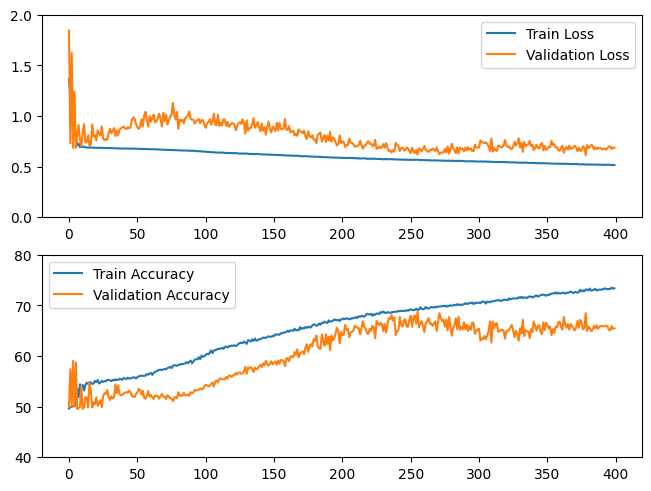

In [40]:
fig, axs = plt.subplots(2, 1)

axs[0].plot(range(len(tr_loss_lst )), tr_loss_lst , label='Train Loss')
axs[0].plot(range(len(val_loss_lst)), val_loss_lst, label='Validation Loss')
axs[0].set_ylim([0,2])

axs[1].plot(range(len(tr_acc_lst)), tr_acc_lst, label='Train Accuracy')
axs[1].plot(range(len(val_acc_lst)), val_acc_lst, label='Validation Accuracy')
axs[1].set_ylim([40,80])

axs[0].legend()
axs[1].legend()
plt.show()

In [38]:
print(f"Best Validation Accuracy is: {best_acc:.2f}%")

Best Validation Accuracy is: 68.77%


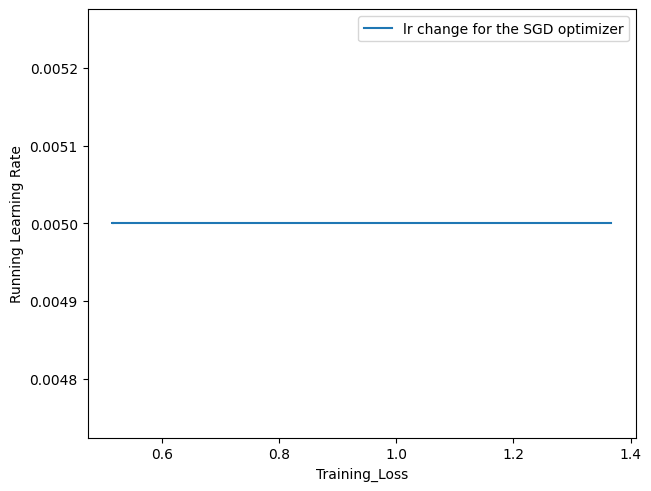

In [39]:
fig, axs = plt.subplots(1, 1)

axs.plot(tr_loss_lst, running_lr_lst, label=f'lr change for the {optimizer_lst[-1]} optimizer')
axs.set_xlabel('Training_Loss')
axs.set_ylabel('Running Learning Rate')
axs.legend()
plt.show()